In [19]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random
import glob 

from analysis import load_events, filter_events
from display import Display
from training.load_games import load_games_new

In [20]:
directory = "../../data/2024-12-03_17-15-19-arena-for-sample-rate-changes"

events_path = max(glob.glob(directory + "/logs_*.txt"))
print(events_path)
events = load_events(events_path)

../../data/2024-12-03_17-15-19-arena-for-sample-rate-changes/logs_2024-12-03_19-07-17_662141.txt
Start time: 1733274964.603611


In [21]:
for event in events:
    if event.name == "loaded_model":
        print(event.params)

{'model_name': 'base_in_notebook_3'}
{'model_name': 'sample_ratio_two_1'}
{'model_name': '002190002'}
{'model_name': 'sample_ratio_two_2'}
{'model_name': 'base_in_notebook_2'}
{'model_name': 'base_in_notebook_1'}


In [22]:
game_result_events = filter_events(events, "game_result")
game_results = [event.params for event in game_result_events]

# I didn't zfill the player names, so we need to do that now
# for sorting to work.
# for game_result in game_results:
#     for result_line in game_result:
#         result_line[0] = result_line[0][1:].zfill(6)

players = set()
for game_result in game_results:
    for player, _ in game_result:
        players.add(player)

# players = sorted(list(players), key=lambda x: int(x))
players = sorted(list(players))

print(players)
print("Number of games:", len(game_results))

['base_in_notebook_1_temp0.3', 'base_in_notebook_1_temp1.0', 'base_in_notebook_2_temp0.3', 'base_in_notebook_2_temp1.0', 'base_in_notebook_3_temp0.3', 'base_in_notebook_3_temp1.0', 'dh_temp0.3', 'dh_temp1.0', 'sample_ratio_two_1_temp0.3', 'sample_ratio_two_1_temp1.0', 'sample_ratio_two_2_temp0.3', 'sample_ratio_two_2_temp1.0']
Number of games: 5198


In [23]:
# Do a naive calculation of average performance per game per player.
player_total_scores = {player: 0 for player in players}
player_total_games = {player: 0 for player in players}

for game_result in game_results:
    for player, result in game_result:
        player_total_scores[player] += result
        player_total_games[player] += 1

player_average_scores = {player: player_total_scores[player] / player_total_games[player] for player in players}
player_average_scores

{'base_in_notebook_1_temp0.3': 0.29917004439297384,
 'base_in_notebook_1_temp1.0': 0.21265501691093566,
 'base_in_notebook_2_temp0.3': 0.2832367149758451,
 'base_in_notebook_2_temp1.0': 0.21169711255156148,
 'base_in_notebook_3_temp0.3': 0.2880782592795754,
 'base_in_notebook_3_temp1.0': 0.20676056338028156,
 'dh_temp0.3': 0.264988687782805,
 'dh_temp1.0': 0.21894073636542621,
 'sample_ratio_two_1_temp0.3': 0.30141536683997644,
 'sample_ratio_two_1_temp1.0': 0.2113554159527888,
 'sample_ratio_two_2_temp0.3': 0.278630164460489,
 'sample_ratio_two_2_temp1.0': 0.22208883553421366}

To use the stuff below, first run enough iterations in the first cell that the elos lines roughly converge. Then, run the bottom cell to generate a plot of the final elos.

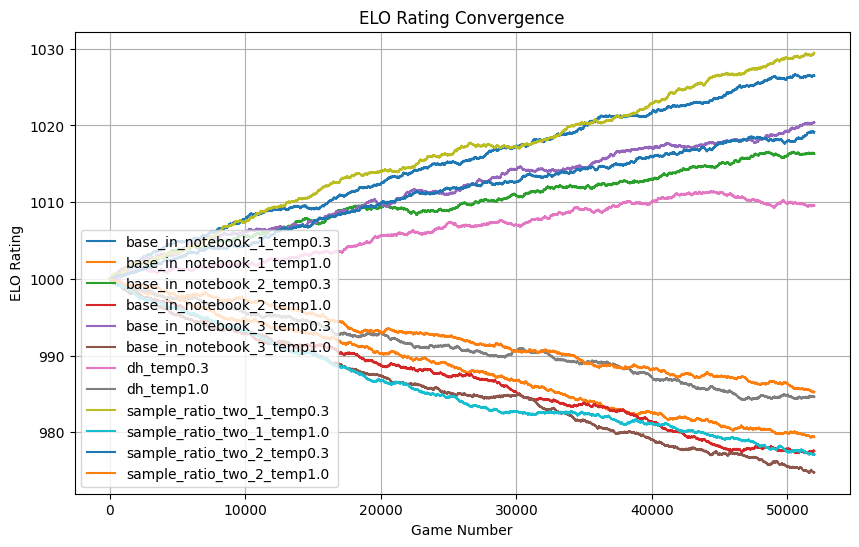

In [24]:
elos = [{player: 1000 for player in players}]

elo_K = 0.05
elo_base = 400.0

for _ in range(len(game_results) * 10):
    game_result = random.choice(game_results)

    latest_elo = elos[-1].copy()

    game_players = [player_name for player_name, _ in game_result]
    Q_player = [10 ** (latest_elo[player] / elo_base) for player in game_players]
    Q_total = sum(Q_player)
    E_player = [Q / Q_total for Q in Q_player]

    for i, (player, result) in enumerate(game_result):
        latest_elo[player] += elo_K * (result - E_player[i])

    elos.append(latest_elo)

# Extract player names from the first dictionary in elos
player_names = elos[0].keys()

# Prepare data for plotting
elo_history = {player: [] for player in player_names}

# Populate elo_history with ELO ratings over time
for elo_snapshot in elos:
    for player in player_names:
        elo_history[player].append(elo_snapshot[player])

# Plot ELO ratings for each player
plt.figure(figsize=(10, 6))
for player, history in elo_history.items():
    plt.plot(history, label=player)

plt.title("ELO Rating Convergence")
plt.xlabel("Game Number")
plt.ylabel("ELO Rating")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

final_elos = elos[-1]

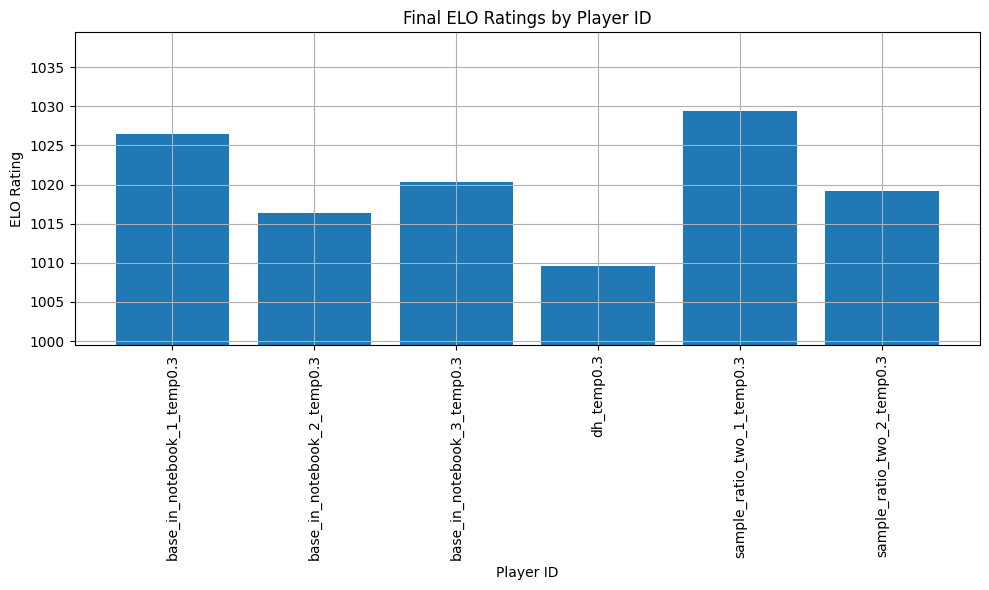

In [27]:
plt.figure(figsize=(10, 6))

filtered_players = [player for player in players if player.endswith("0.3")]

elos_y = [final_elos[player] for player in filtered_players]
plt.bar(filtered_players, elos_y)

plt.title("Final ELO Ratings by Player ID")
plt.xlabel("Player ID")
plt.xticks(rotation=90)
plt.ylabel("ELO Rating")
plt.grid(True)
plt.ylim(bottom=min(elos_y) - 10, top=max(elos_y) + 10)  # Set y-axis to start at 900
plt.tight_layout()
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'marker'

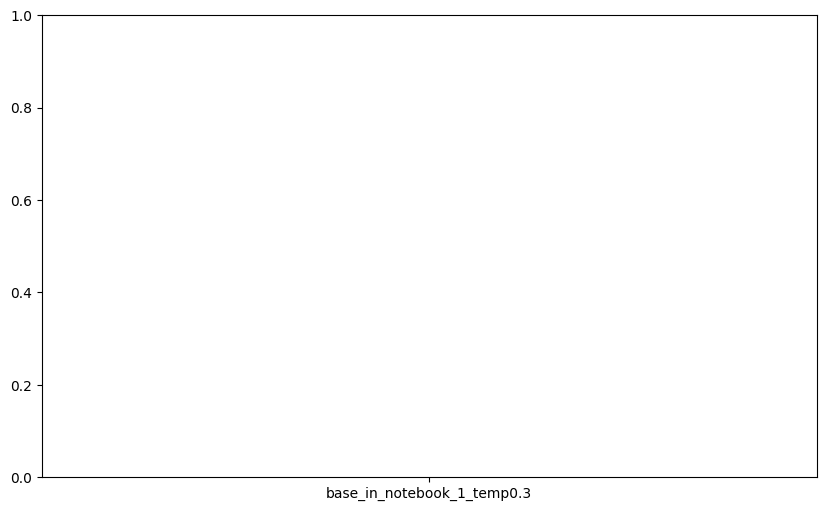

In [185]:
plt.figure(figsize=(10, 6))

elos_x = [player for player in players]
elos_y = [final_elos[player] for player in players]
plt.bar(elos_x, elos_y, marker='o')
plt.legend()

plt.title("Final ELO Ratings by Player ID")
plt.xlabel("Player ID")
plt.ylabel("ELO Rating")
plt.grid(True)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(left=0)  # Set x-axis to start at 0
plt.tight_layout()
plt.show()

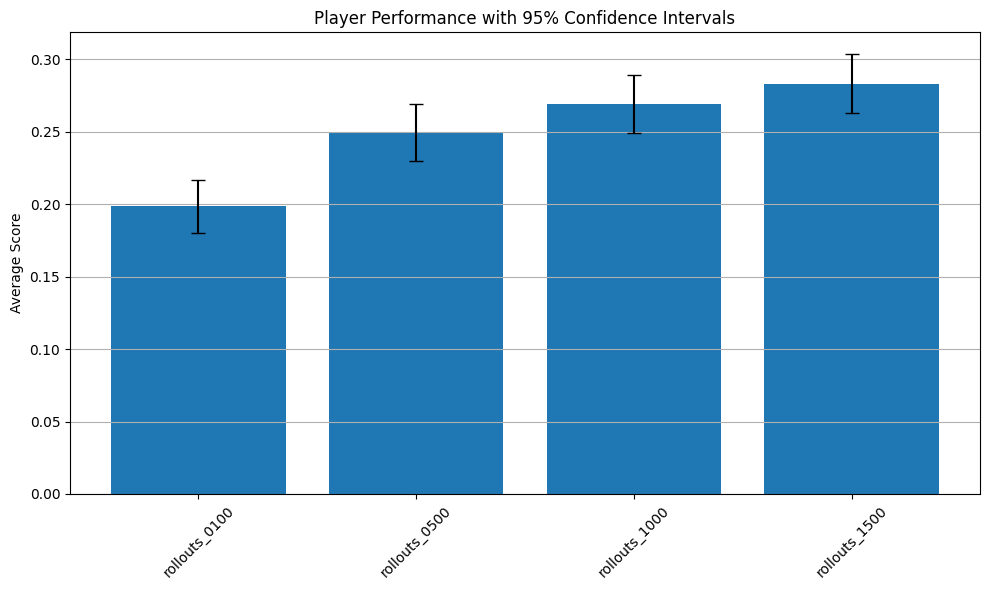

In [17]:
player_results = {}
total_results = {}
for game_result in game_results:
    for player, result in game_result:
        total_results[player] = total_results.get(player, 0) + result
        player_results[player] = player_results.get(player, []) + [result]

player_average = {}
sum_of_total_results = sum(total_results.values())
for player in total_results:
    player_average[player] = total_results[player] / sum_of_total_results

player_error_range = {}
for player in player_results:
    std = np.std(player_results[player]) / np.sqrt(len(player_results[player]))
    player_error_range[player] = 1.96 * std

plt.figure(figsize=(10, 6))

sorted_players = sorted(player_average.items(), key=lambda x: x[0])
players = [p[0] for p in sorted_players]
averages = [player_average[p] for p in players]
errors = [player_error_range[p] for p in players]

plt.bar(players, averages, yerr=errors, capsize=5)
plt.title("Player Performance with 95% Confidence Intervals")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [123]:
# Analyze how many different terminal states were reached.
game_files = glob.glob(directory + "/games/*")
gamedata = load_games_new(game_files)

In [124]:
np.unique(gamedata["game_ids"]).shape[0]

1536

In [125]:
terminal_board_indices = []
terminal_boards = []
for i in range(len(gamedata["game_ids"]) - 1):
    if gamedata["game_ids"][i] != gamedata["game_ids"][i + 1]:
        terminal_board_indices.append(i)
        terminal_boards.append(gamedata["boards"][i])

terminal_boards = np.array(terminal_boards)

In [127]:
print("Number of terminal boards:", terminal_boards.shape[0])
print("Number of unique terminal boards:", np.unique(terminal_boards, axis=0).shape[0])

Number of terminal boards: 1535
Number of unique terminal boards: 1376


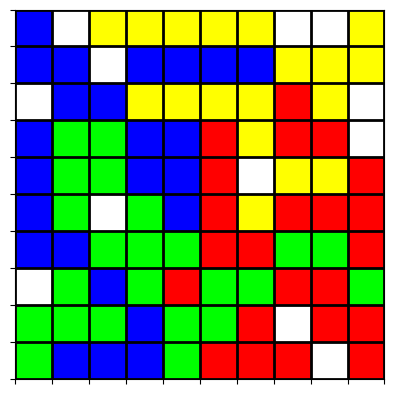

In [31]:
Display(terminal_boards[50]).show()

In [20]:
terminal_board_indices[30]

673